Setting and importing necessary library

In [5]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Load Data

In [6]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
import numpy as np

In [43]:
# Load datasets
users = pd.read_csv('/kaggle/input/movieslen/ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('/kaggle/input/movieslen/ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['movie_id', 'title', 'genres'], encoding='latin1')
ratings = pd.read_csv('/kaggle/input/movieslen/ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [41]:
users

user_id  gender  age  occupation zip_code
0           1       0    1          10    48067
1           2       0   56          16    70072
2           3       0   25          15    55117
3           4       0   45           7    02460
4           5       0   25          20    55455
...       ...     ...  ...         ...      ...
6035     6036       0   25          15    32603
6036     6037       0   45           1    76006
6037     6038       0   56           1    14706
6038     6039       0   45           0    01060
6039     6040       0   25           6    11106

[6040 rows x 5 columns]

In [ ]:
movies

movie_id                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
3878      3948             Meet the Parents (2000)   
3879      3949          Requiem for a Dream (2000)   
3880      3950                    Tigerland (2000)   
3881      3951             Two Family House (2000)   
3882      3952               Contender, The (2000)   

                            genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880                         Drama  
3881                         Drama  
3882                Drama|Thriller  

[3883 rows x 3 columns]

In [ ]:
ratings

user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]

In [ ]:
users.describe()

user_id          age   occupation
count  6040.000000  6040.000000  6040.000000
mean   3020.500000    30.639238     8.146854
std    1743.742145    12.895962     6.329511
min       1.000000     1.000000     0.000000
25%    1510.750000    25.000000     3.000000
50%    3020.500000    25.000000     7.000000
75%    4530.250000    35.000000    14.000000
max    6040.000000    56.000000    20.000000

In [ ]:
movies.describe()

movie_id
count  3883.000000
mean   1986.049446
std    1146.778349
min       1.000000
25%     982.500000
50%    2010.000000
75%    2980.500000
max    3952.000000

In [ ]:
ratings.describe()

user_id      movie_id        rating     timestamp
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.722437e+08
std    1.728413e+03  1.096041e+03  1.117102e+00  1.215256e+07
min    1.000000e+00  1.000000e+00  1.000000e+00  9.567039e+08
25%    1.506000e+03  1.030000e+03  3.000000e+00  9.653026e+08
50%    3.070000e+03  1.835000e+03  4.000000e+00  9.730180e+08
75%    4.476000e+03  2.770000e+03  4.000000e+00  9.752209e+08
max    6.040000e+03  3.952000e+03  5.000000e+00  1.046455e+09

# Preprocessing

In [ ]:
len(np.unique(users['user_id'])) == len(users['user_id'])

True

In [ ]:
len(np.unique(movies['movie_id'])) == len(movies['movie_id'])

True

In [ ]:
len(np.unique(ratings['movie_id'])) < len(np.unique(movies['movie_id']))

True

In [ ]:
len(np.unique(ratings['user_id'])) == len(np.unique(users['user_id']))

True

In [ ]:
# Encode gender as numerical
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
# Encode genres using one-hot encoding
all_genres = set(g for genres in movies['genres'].str.split('|') for g in genres)
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split('|')))
movies = movies.drop('genres', axis=1)

In [ ]:
# Mapping of user IDs to consecutive values
unique_user_id = users['user_id'].unique()

unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
unique_user_id.head()

userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

In [ ]:
# Mapping of movie IDs to consecutive values
unique_movie_id = movies['movie_id'].unique()

unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
unique_movie_id.head()

movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4

## Graph Transfrom

In [6]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T

In [7]:
data = HeteroData()

In [8]:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies))

NameError: name 'unique_user_id' is not defined

In [ ]:
# Chuẩn bị dữ liệu người dùng (user nodes)
user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
data['user'].x = user_features

# Chuẩn bị dữ liệu phim (movie nodes)
movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
data['movie'].x = movie_features

In [ ]:
# Tạo edges dựa trên ratings
merged_user = ratings.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
merged_movie = ratings.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
ratings_user_id = torch.from_numpy(merged_user['mappedID'].values)
ratings_movie_id = torch.from_numpy(merged_movie['mappedID'].values)
edge_index = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
# edge_index = torch.tensor([ratings['user_id'].values - 1, ratings['movie_id'].values - 1], dtype=torch.long)

data['user', 'rates', 'movie'].edge_index = edge_index
# data['user', 'rates', 'movie'].edge_label = torch.from_numpy(ratings['rating'].values).to(torch.float)

In [ ]:
# Tạo trọng số cho các cạnh (dùng rating làm trọng số)
edge_weight = torch.tensor(ratings['rating'].values, dtype=torch.float)
data['user', 'rates', 'movie'].edge_attr = edge_weight  # Gắn trọng số vào các cạnh

In [ ]:
data = T.ToUndirected()(data)
data

HeteroData(
  user={
    node_id=[6040],
    x=[6040, 3],
  },
  movie={
    node_id=[3883],
    x=[3883, 18],
  },
  (user, rates, movie)={
    edge_index=[2, 1000209],
    edge_attr=[1000209],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 1000209],
    edge_attr=[1000209],
  }
)

Train test split

In [ ]:
data["user", "rates", "movie"]['x_dict'] = data.x_dict

In [ ]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.2,        # 20% dữ liệu cho validation
    num_test=0.0,       # 0% dữ liệu cho test
    disjoint_train_ratio=0.3,  # Tỷ lệ tập huấn luyện không chồng lấp với validation/test
    add_negative_train_samples=False,  # Tạo mẫu âm cho tập huấn luyện
    edge_types=("user", "rates", "movie"),  # Loại liên kết
    rev_edge_types=("movie", "rev_rates", "user"),  # Các liên kết nghịch đảo
)(data)
train_data, val_data, test_data

(HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (user, rates, movie)={
     edge_index=[2, 560118],
     edge_attr=[560118],
     x_dict={
       user=[6040, 3],
       movie=[3883, 18],
     },
     edge_label=[240050],
     edge_label_index=[2, 240050],
   },
   (movie, rev_rates, user)={
     edge_index=[2, 560118],
     edge_attr=[560118],
   }
 ),
 HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (user, rates, movie)={
     edge_index=[2, 800168],
     edge_attr=[800168],
     x_dict={
       user=[6040, 3],
       movie=[3883, 18],
     },
     edge_label=[400082],
     edge_label_index=[2, 400082],
   },
   (movie, rev_rates, user)={
     edge_index=[2, 800168],
     edge_attr=[800168],
   }
 ),
 HeteroData(
   user={
     node_id=[6040],
     x=[6040, 3],
   },
   movie={
     node_id=[3883],
     x=[3883, 18],
   },
   (u

In [ ]:
train_data["user", "rates", "movie"].edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
val_data["user", "rates", "movie"].edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [ ]:
type(train_data["user", "rates", "movie"])

torch_geometric.data.storage.EdgeStorage

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

In [ ]:


# get node id of source and distance
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label_index.shape

torch.Size([2, 240050])

In [ ]:
# get value of edges
edge_label = train_data["user", "rates", "movie"].edge_label
edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Build GNN

In [32]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

from torch import Tensor

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.user_lin = torch.nn.Linear(3, hidden_channels)
        self.movie_lin = torch.nn.Linear(18, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_lin(data["user"].x) + self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        if "edge_label_index" in data["user", "rates", "movie"]:
            edge_label_index = data["user", "rates", "movie"].edge_label_index
        else:
            edge_label_index = data["user", "rates", "movie"].edge_index
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            edge_label_index,
        )
        return pred

model = Model(hidden_channels=64)

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv

class GNNRecommendationModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super(GNNRecommendationModel, self).__init__()

        # GCN layers
        self.gcn_user = GCNConv(3, hidden_dim)
        self.gcn_movie = GCNConv(18, hidden_dim)

        # MLP for prediction (output is the predicted rating)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, data):
        # Đặc trưng của người dùng và phim
        user_x = data['user'].x
        movie_x = data['movie'].x

        # Edge indices và edge weights
        edge_index = data['user', 'rates', 'movie'].edge_index
        edge_attr = data['user', 'rates', 'movie'].edge_attr


        # GCN cho người dùng
        user_out = self.gcn_user(user_x, edge_index, edge_attr)
        print("ha")
        # GCN cho phim
        movie_out = self.gcn_movie(movie_x, edge_index, edge_attr)
        print(edge_attr)
        # Ghép đặc trưng người dùng và phim cho mỗi cạnh
        out = torch.cat([user_out, movie_out], dim=-1)

        # Dự đoán rating từ MLP
        rating_pred = self.mlp(out)

        return rating_pred

# Training

In [ ]:
sageconvloss=[]

In [ ]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cpu'


In [ ]:
print("Training model with sageconv")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs=10
for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}",sep='')
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Loss: {total_loss / total_examples:.4f}")
    loss = total_loss / total_examples
    sageconvloss.append(round(loss, 4))

NameError: name 'fkprint' is not defined

In [ ]:
torch.save(model.state_dict(), "model_gnn.pth")

In [ ]:
model = Model(hidden_channels=64)

model.load_state_dict(torch.load("model_gnn.pth", map_location=torch.device('cpu')))
model.eval()

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
plt.plot(epochs, sageconvloss, label='SageConv Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss SageConv')
plt.legend()
plt.show()

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Khởi tạo mô hình
model = GNNRecommendationModel()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Loss function (MSE loss)
def train(model, dataa):
    model.train()
    optimizer.zero_grad()

    # Lấy đầu ra từ mô hình
    rating_pred = model(dataa)

    # Lấy nhãn (ratings thực tế)
    true_ratings = dataa['user', 'rates', 'movie'].edge_attr  # Trọng số cạnh chính là rating thực tế

    # Tính loss
    loss = F.mse_loss(rating_pred.view(-1), true_ratings)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item()

# Huấn luyện mô hình
for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}",sep='')
    for sampled_data in tqdm.tqdm(train_loader):
      sampled_data.to(device)
      loss = train(model, sampled_data)
      print(f"Loss: {loss:.4f}")

## K-Flod Cross Validation

In [44]:
# Encode gender as numerical
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [45]:
# Encode genres using one-hot encoding
all_genres = set(g for genres in movies['genres'].str.split('|') for g in genres)
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split('|')))
movies = movies.drop('genres', axis=1)

In [46]:
unique_user_id = users['user_id'].unique()

unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})

# Mapping of movie IDs to consecutive values
unique_movie_id = movies['movie_id'].unique()

unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
unique_movie_id.head()

movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4

In [47]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# Số lượng fold
k = 10
# Khởi tạo K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [48]:
# Duyệt qua từng fold
fold_data = []
for fold, (train_idx, val_idx) in enumerate(kf.split(ratings)):
    train_data = ratings.iloc[train_idx]
    val_data = ratings.iloc[val_idx]

    print(f"Fold {fold + 1}")
    print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")
    fold_data.append((train_data, val_data))

Fold 1
Train size: 900188, Validation size: 100021
Fold 2
Train size: 900188, Validation size: 100021
Fold 3
Train size: 900188, Validation size: 100021
Fold 4
Train size: 900188, Validation size: 100021
Fold 5
Train size: 900188, Validation size: 100021
Fold 6
Train size: 900188, Validation size: 100021
Fold 7
Train size: 900188, Validation size: 100021
Fold 8
Train size: 900188, Validation size: 100021
Fold 9
Train size: 900188, Validation size: 100021
Fold 10
Train size: 900189, Validation size: 100020


In [50]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
import numpy as np
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T

In [51]:
from torch_geometric.data import Data

# Tạo danh sách chứa các đồ thị cho từng fold
graph_folds = []

for train_data, val_data in fold_data:
    # Chuẩn bị edge_index và edge_attr cho train
    train_merged_user = train_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    train_merged_movie = train_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    train_edge_index = torch.stack([
        torch.tensor(train_merged_user['mappedID'].values),
        torch.tensor(train_merged_movie['mappedID'].values)
    ], dim=0)
    train_edge_attr = torch.tensor(train_data['rating'].values, dtype=torch.float)

    # Tương tự cho validation
    val_merged_user = val_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    val_merged_movie = val_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    val_edge_index = torch.stack([
        torch.tensor(val_merged_user['mappedID'].values),
        torch.tensor(val_merged_movie['mappedID'].values)
    ], dim=0)
    val_edge_attr = torch.tensor(val_data['rating'].values, dtype=torch.float)

    # Tạo đồ thị train và val
    train_graph = HeteroData()
    train_graph['user', 'rates', 'movie'].edge_index = train_edge_index
    train_graph['user', 'rates', 'movie'].edge_attr = train_edge_attr
    train_graph = T.ToUndirected()(train_graph)


    val_graph = HeteroData()
    val_graph['user', 'rates', 'movie'].edge_index = val_edge_index
    val_graph['user', 'rates', 'movie'].edge_attr = val_edge_attr
    val_graph = T.ToUndirected()(val_graph)

    graph_folds.append((train_graph, val_graph))

In [52]:
# Áp dụng transform RandomLinkSplit:
import torch_geometric.transforms as T
transform = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.0,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

In [53]:
train_loader_list = []
val_loader_list = []
test_loader_list = []

In [54]:
print(graph_folds[1])

(HeteroData(
  (user, rates, movie)={
    edge_index=[2, 900188],
    edge_attr=[900188],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 900188],
    edge_attr=[900188],
  }
), HeteroData(
  (user, rates, movie)={
    edge_index=[2, 100021],
    edge_attr=[100021],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 100021],
    edge_attr=[100021],
  }
))


In [56]:
from torch_geometric.data import Data

# Tạo danh sách chứa các đồ thị cho từng fold
graph_folds = []

for train_data, val_data in fold_data:
    # Chuẩn bị edge_index và edge_attr cho train
    train_merged_user = train_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    train_merged_movie = train_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    train_edge_index = torch.stack([
        torch.tensor(train_merged_user['mappedID'].values),
        torch.tensor(train_merged_movie['mappedID'].values)
    ], dim=0)
    train_edge_attr = torch.tensor(train_data['rating'].values, dtype=torch.float)

    # Tương tự cho validation
    val_merged_user = val_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    val_merged_movie = val_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    val_edge_index = torch.stack([
        torch.tensor(val_merged_user['mappedID'].values),
        torch.tensor(val_merged_movie['mappedID'].values)
    ], dim=0)
    val_edge_attr = torch.tensor(val_data['rating'].values, dtype=torch.float)

    # Tạo đồ thị train và val
    train_graph = HeteroData()
    train_graph['user', 'rates', 'movie'].edge_index = train_edge_index
    train_graph['user', 'rates', 'movie'].edge_attr = train_edge_attr
    train_graph = T.ToUndirected()(train_graph)


    val_graph = HeteroData()
    val_graph['user', 'rates', 'movie'].edge_index = val_edge_index
    val_graph['user', 'rates', 'movie'].edge_attr = val_edge_attr
    val_graph = T.ToUndirected()(val_graph)

    graph_folds.append((train_graph, val_graph))

# Bây giờ, graph_folds chứa K bộ train/val đồ thị


In [57]:
# Tập hợp tất cả các user_id và movie_id
all_users = set(unique_user_id)
all_movies = set(unique_movie_id)

for fold_idx, (train_graph, val_graph) in enumerate(graph_folds):
    train_graph["user"].node_id = torch.arange(len(unique_user_id))
    train_graph["movie"].node_id = torch.arange(len(movies))

    user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
    train_graph['user'].x = user_features

    # Chuẩn bị dữ liệu phim (movie nodes)
    movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
    train_graph['movie'].x = movie_features

    val_graph["user"].node_id = torch.arange(len(unique_user_id))
    val_graph["movie"].node_id = torch.arange(len(movies))

    user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
    val_graph['user'].x = user_features

    # Chuẩn bị dữ liệu phim (movie nodes)
    movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
    val_graph['movie'].x = movie_features
    # Cập nhật đồ thị train
    graph_folds[fold_idx] = (train_graph, val_graph)


In [58]:
# Áp dụng transform RandomLinkSplit:
import torch_geometric.transforms as T
transform = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.0,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

In [61]:
train_loader_list = []
val_loader_list = []
test_loader_list = []

In [ ]:
len(graph_folds)

10

In [62]:
for fold in graph_folds:
    train_data, _, _ = transform(fold[0])
    val_data, _, _ = transform(fold[1])

    # Define seed edges:
    edge_label_index = train_data["user", "rates", "movie"].edge_label_index
    edge_label = train_data["user", "rates", "movie"].edge_label

    train_loader = LinkNeighborLoader(
        data=train_data,  # TODO
        num_neighbors=[20, 10],  # TODO
        neg_sampling_ratio=2.0,  # TODO
        edge_label_index=(("user", "rates", "movie"), edge_label_index),
        edge_label=edge_label,
        batch_size=2048,
        shuffle=True,
    )

    # Define seed edges:
    edge_label_index = val_data["user", "rates", "movie"].edge_label_index
    edge_label = val_data["user", "rates", "movie"].edge_label

    val_loader = LinkNeighborLoader(
        data=val_data,  # TODO
        num_neighbors=[20, 10],  # TODO
        neg_sampling_ratio=2.0,  # TODO
        edge_label_index=(("user", "rates", "movie"), edge_label_index),
        edge_label=edge_label,
        batch_size=2048,
        shuffle=True,
    )

    train_loader_list.append(train_loader)
    val_loader_list.append(val_loader)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [63]:
data = torch.load("/kaggle/input/ghgjhghhgg/graphData.pt")

<ipython-input-63-cefff922f9b6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("/kaggle/input/ghgjhghhgg/graphData.pt")


In [64]:
foldloss = []
foldvalroc=[]
predict = []
truth = []

In [30]:
from sklearn.metrics import roc_auc_score

In [65]:
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# from torch_geometric.nn import DataParallel
# from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
print("Training model with SageConv")

# model = DataParallel(model)

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
n_epochs=1
model.train(True)
for idx, (train_loaderloader, val_loader) in enumerate(zip(train_loader_list,val_loader_list)):
    print(f"FOLD: {idx + 1}")
    sageconvloss=[]
    sagevalroc=[]
    model = Model(hidden_channels=64)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(20):
        model.train(True)
        total_loss = total_examples = 0
        print(f"Epoch: {epoch+1}",sep='')

        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            loss.backward()
            optimizer.step()
            # scheduler.step(loss)
            optimizer.zero_grad()
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        model.eval()
        preds = []
        ground_truths = []
        for sampled_data in tqdm.tqdm(val_loader):
            with torch.no_grad():
                sampled_data.to(device)
                preds.append(model(sampled_data))
                ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

        auc = roc_auc_score(ground_truth, pred)
        print(f"Loss: {total_loss / total_examples:.4f}, AUC on val: {auc}")
        loss = total_loss / total_examples
        sageconvloss.append(round(loss, 4))
        sagevalroc.append(auc)
    foldloss.append(sageconvloss)
    foldvalroc.append(sagevalroc)
    predict.append(pred)
    truth.append(ground_truth)

Device: 'cuda'
Training model with SageConv
FOLD: 1
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Loss: 6.5000, AUC on val: 0.6485178111015136
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.6852, AUC on val: 0.6955122867092692
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.6006, AUC on val: 0.7225704723526845
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 0.5553, AUC on val: 0.7405185537910748
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Loss: 0.5257, AUC on val: 0.7589067433352851
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.5183, AUC on val: 0.7709025256536375
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


Loss: 0.4897, AUC on val: 0.7790279037884795
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.72it/s]


Loss: 0.4774, AUC on val: 0.7924326821742675
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.49it/s]


Loss: 0.4702, AUC on val: 0.7994243752173824
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.86it/s]


Loss: 0.4585, AUC on val: 0.8085061321513386
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Loss: 0.4498, AUC on val: 0.8169321783402657
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Loss: 0.4407, AUC on val: 0.824478071903227
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


Loss: 0.4339, AUC on val: 0.8291599023171214
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4283, AUC on val: 0.8357034610207865
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 11.76it/s]


Loss: 0.4250, AUC on val: 0.8424601625143655
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 11.99it/s]


Loss: 0.4151, AUC on val: 0.846426117362677
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.54it/s]


Loss: 0.4082, AUC on val: 0.8548119149304401
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Loss: 0.4104, AUC on val: 0.8566412411823219
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


Loss: 0.4000, AUC on val: 0.8645828233984387
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 13.03it/s]


Loss: 0.4004, AUC on val: 0.865894695541551
FOLD: 2
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 2.2898, AUC on val: 0.6819038125877013
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.79it/s]


Loss: 0.5849, AUC on val: 0.727319007470918
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Loss: 0.5366, AUC on val: 0.7545771009209921
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.5054, AUC on val: 0.7799684339276916
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 13.03it/s]


Loss: 0.4839, AUC on val: 0.7964447433004456
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Loss: 0.4694, AUC on val: 0.8042600749107438
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Loss: 0.4542, AUC on val: 0.8172350282992791
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.4427, AUC on val: 0.8283896879336834
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 13.01it/s]


Loss: 0.4337, AUC on val: 0.8374562362294811
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.4228, AUC on val: 0.8452644262522554
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 0.4148, AUC on val: 0.8522624634241318
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.4065, AUC on val: 0.8578838560311222
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


Loss: 0.3991, AUC on val: 0.8658884050024627
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Loss: 0.3928, AUC on val: 0.8701764837661008
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.86it/s]


Loss: 0.3868, AUC on val: 0.8749071299295208
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Loss: 0.3828, AUC on val: 0.8753331667199853
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Loss: 0.3804, AUC on val: 0.8806648990915451
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.3785, AUC on val: 0.8828161762723995
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Loss: 0.3736, AUC on val: 0.8847972462651597
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


Loss: 0.3708, AUC on val: 0.88694024175902
FOLD: 3
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 3.1209, AUC on val: 0.6557790635323134
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.86it/s]


Loss: 0.6091, AUC on val: 0.6974058705888629
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Loss: 0.5554, AUC on val: 0.7295813071827635
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Loss: 0.5207, AUC on val: 0.7555031687901349
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.24it/s]


Loss: 0.4975, AUC on val: 0.7721706222531628
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


Loss: 0.4801, AUC on val: 0.7857510201063611
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 0.4670, AUC on val: 0.8006373516449591
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


Loss: 0.4559, AUC on val: 0.8077126629041096
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.72it/s]


Loss: 0.4457, AUC on val: 0.8142186991182714
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.38it/s]


Loss: 0.4357, AUC on val: 0.8212506324525493
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.57it/s]


Loss: 0.4277, AUC on val: 0.8279039930643923
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 11.89it/s]


Loss: 0.4218, AUC on val: 0.8320124361894712
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


Loss: 0.4144, AUC on val: 0.8408976553575064
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.57it/s]


Loss: 0.4077, AUC on val: 0.844909459641987
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


Loss: 0.4025, AUC on val: 0.8516338112990169
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.78it/s]


Loss: 0.3960, AUC on val: 0.8599173953118462
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.65it/s]


Loss: 0.3911, AUC on val: 0.8595126511146036
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.30it/s]


Loss: 0.3864, AUC on val: 0.8649008570056079
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


Loss: 0.3817, AUC on val: 0.8684010920493588
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.76it/s]


Loss: 0.3789, AUC on val: 0.8728644640220349
FOLD: 4
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.77it/s]


Loss: 2.1128, AUC on val: 0.679335430321121
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.38it/s]


Loss: 0.5967, AUC on val: 0.7192004413332268
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Loss: 0.5483, AUC on val: 0.7508593767704723
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.5074, AUC on val: 0.771405223998636
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Loss: 0.4913, AUC on val: 0.7889537661020751
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.81it/s]


Loss: 0.4706, AUC on val: 0.7974435206939815
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.76it/s]


Loss: 0.4558, AUC on val: 0.8075543031987704
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


Loss: 0.4447, AUC on val: 0.8164628544219393
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.96it/s]


Loss: 0.4373, AUC on val: 0.8223528501324997
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Loss: 0.4274, AUC on val: 0.8326389294559937
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.40it/s]


Loss: 0.4194, AUC on val: 0.8405824650573451
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Loss: 0.4132, AUC on val: 0.8485381438564872
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Loss: 0.4054, AUC on val: 0.8539446463170207
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.70it/s]


Loss: 0.3997, AUC on val: 0.8599967269093671
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.49it/s]


Loss: 0.3935, AUC on val: 0.866531972827368
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.3885, AUC on val: 0.8706551159052109
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.3863, AUC on val: 0.8733923428493887
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.3810, AUC on val: 0.8767292224085343
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.3786, AUC on val: 0.8781375140355518
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Loss: 0.3750, AUC on val: 0.8796280483177732
FOLD: 5
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Loss: 4.7074, AUC on val: 0.683854583867825
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.05it/s]


Loss: 0.6257, AUC on val: 0.7264027306849501
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.5525, AUC on val: 0.7579574494796879
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.51it/s]


Loss: 0.5147, AUC on val: 0.7734933625485794
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 11.50it/s]


Loss: 0.4934, AUC on val: 0.788437717542141
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.4772, AUC on val: 0.8005498052781188
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.4629, AUC on val: 0.8072174343486742
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


Loss: 0.4549, AUC on val: 0.815408964908789
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Loss: 0.4448, AUC on val: 0.8248861386602014
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 13.04it/s]


Loss: 0.4380, AUC on val: 0.8291017550228095
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.4300, AUC on val: 0.8315688161552297
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


Loss: 0.4238, AUC on val: 0.8404844356619133
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.70it/s]


Loss: 0.4178, AUC on val: 0.8440560371562293
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.98it/s]


Loss: 0.4132, AUC on val: 0.8490414458488915
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.4072, AUC on val: 0.8553351553355708
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4030, AUC on val: 0.8592208084189112
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.38it/s]


Loss: 0.3973, AUC on val: 0.863924007229037
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 0.3921, AUC on val: 0.8686033142079619
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Loss: 0.3879, AUC on val: 0.8711172746343442
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.3851, AUC on val: 0.8748692917329794
FOLD: 6
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.51it/s]


Loss: 3.2511, AUC on val: 0.6799074848097767
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Loss: 0.6041, AUC on val: 0.7238303525168903
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.72it/s]


Loss: 0.5578, AUC on val: 0.7500750491440071
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Loss: 0.5278, AUC on val: 0.7704429461704807
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


Loss: 0.5094, AUC on val: 0.7867410593288484
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Loss: 0.4825, AUC on val: 0.798416858542131
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.39it/s]


Loss: 0.4757, AUC on val: 0.8074860999272517
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Loss: 0.4594, AUC on val: 0.8167310568524612
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 0.4492, AUC on val: 0.8229370278269437
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Loss: 0.4418, AUC on val: 0.8329120032711004
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Loss: 0.4328, AUC on val: 0.8411056263274661
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.4251, AUC on val: 0.8456958036840275
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Loss: 0.4177, AUC on val: 0.8509594294120802
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


Loss: 0.4087, AUC on val: 0.8592398144268589
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Loss: 0.4042, AUC on val: 0.8632040258059611
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


Loss: 0.3980, AUC on val: 0.869278857297038
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.68it/s]


Loss: 0.3917, AUC on val: 0.8720246111079057
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.35it/s]


Loss: 0.3866, AUC on val: 0.875509892966862
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 11.48it/s]


Loss: 0.3808, AUC on val: 0.877304874346955
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.65it/s]


Loss: 0.3803, AUC on val: 0.881286831960187
FOLD: 7
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 3.9081, AUC on val: 0.68926373749001
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.76it/s]


Loss: 0.5911, AUC on val: 0.7368123436456036
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.37it/s]


Loss: 0.5347, AUC on val: 0.7619703766483034
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.78it/s]


Loss: 0.5072, AUC on val: 0.78117962051572
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.4870, AUC on val: 0.796982630346334
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.4714, AUC on val: 0.8045480402686376
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.81it/s]


Loss: 0.4613, AUC on val: 0.8148448963920918
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


Loss: 0.4496, AUC on val: 0.822944174412468
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 0.4414, AUC on val: 0.8296146867740362
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 0.4356, AUC on val: 0.8366324399476123
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.4267, AUC on val: 0.8419815245442546
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.4208, AUC on val: 0.8502566747087384
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Loss: 0.4145, AUC on val: 0.8531380364932146
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.85it/s]


Loss: 0.4092, AUC on val: 0.857556431180826
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Loss: 0.4027, AUC on val: 0.8625688801674001
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.79it/s]


Loss: 0.3979, AUC on val: 0.8668156185244099
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


Loss: 0.3940, AUC on val: 0.8700132848855144
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.22it/s]


Loss: 0.3906, AUC on val: 0.8737165048382934
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


Loss: 0.3862, AUC on val: 0.8765166888193602
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.76it/s]


Loss: 0.3837, AUC on val: 0.8787002197640855
FOLD: 8
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 3.9294, AUC on val: 0.6724059954278112
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Loss: 0.6117, AUC on val: 0.7100111835150356
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Loss: 0.5520, AUC on val: 0.7449782011426371
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


Loss: 0.5188, AUC on val: 0.7673312434760265
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.98it/s]


Loss: 0.4975, AUC on val: 0.781402755141833
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Loss: 0.4830, AUC on val: 0.7938203712098122
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 13.03it/s]


Loss: 0.4680, AUC on val: 0.8040794485573991
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Loss: 0.4552, AUC on val: 0.8114545823755331
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.96it/s]


Loss: 0.4487, AUC on val: 0.8216533380208804
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


Loss: 0.4366, AUC on val: 0.8308080963069311
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.4289, AUC on val: 0.8365486098718846
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Loss: 0.4214, AUC on val: 0.8427177247569437
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4140, AUC on val: 0.8519632853295591
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


Loss: 0.4089, AUC on val: 0.8547606951426263
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Loss: 0.4020, AUC on val: 0.8610273654460603
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.78it/s]


Loss: 0.3971, AUC on val: 0.8638756215852299
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


Loss: 0.3909, AUC on val: 0.8691120276466824
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.86it/s]


Loss: 0.3878, AUC on val: 0.872602589337939
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.96it/s]


Loss: 0.3832, AUC on val: 0.875659046632763
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Loss: 0.3797, AUC on val: 0.8789277007070536
FOLD: 9
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 11.97it/s]


Loss: 2.7442, AUC on val: 0.6770953919816141
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 11.54it/s]


Loss: 0.5813, AUC on val: 0.7200084142228631
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


Loss: 0.5388, AUC on val: 0.7531197525297535
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 13.01it/s]


Loss: 0.5064, AUC on val: 0.7792704420412546
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 13.05it/s]


Loss: 0.4835, AUC on val: 0.7960632739589965
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4652, AUC on val: 0.8104523155445784
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.62it/s]


Loss: 0.4522, AUC on val: 0.8199522618527241
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


Loss: 0.4412, AUC on val: 0.8282683028814486
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4305, AUC on val: 0.8335929217098215
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Loss: 0.4230, AUC on val: 0.8431073027990328
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


Loss: 0.4157, AUC on val: 0.8471037443403364
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 13.01it/s]


Loss: 0.4091, AUC on val: 0.8534321971505185
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.94it/s]


Loss: 0.4029, AUC on val: 0.859935322029331
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Loss: 0.3973, AUC on val: 0.8635549587520787
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


Loss: 0.3914, AUC on val: 0.8693127573467733
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.3863, AUC on val: 0.8732473186426503
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.54it/s]


Loss: 0.3833, AUC on val: 0.8756029196413601
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.51it/s]


Loss: 0.3810, AUC on val: 0.8782769815762901
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Loss: 0.3778, AUC on val: 0.8831661423830678
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


Loss: 0.3748, AUC on val: 0.8829922513908646
FOLD: 10
Epoch: 1


100%|██████████| 15/15 [00:01<00:00, 12.37it/s]


Loss: 2.3723, AUC on val: 0.6771189522787748
Epoch: 2


100%|██████████| 15/15 [00:01<00:00, 12.55it/s]


Loss: 0.5823, AUC on val: 0.7233684128667834
Epoch: 3


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


Loss: 0.5331, AUC on val: 0.7583603338653737
Epoch: 4


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


Loss: 0.4973, AUC on val: 0.7800550576080878
Epoch: 5


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


Loss: 0.4742, AUC on val: 0.7996421167231815
Epoch: 6


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


Loss: 0.4584, AUC on val: 0.8122861971963402
Epoch: 7


100%|██████████| 15/15 [00:01<00:00, 12.79it/s]


Loss: 0.4469, AUC on val: 0.8184946966037929
Epoch: 8


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


Loss: 0.4379, AUC on val: 0.8264254692552793
Epoch: 9


100%|██████████| 15/15 [00:01<00:00, 12.68it/s]


Loss: 0.4310, AUC on val: 0.8328323084855357
Epoch: 10


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Loss: 0.4248, AUC on val: 0.8365784695934683
Epoch: 11


100%|██████████| 15/15 [00:01<00:00, 12.82it/s]


Loss: 0.4177, AUC on val: 0.841910330802377
Epoch: 12


100%|██████████| 15/15 [00:01<00:00, 12.55it/s]


Loss: 0.4118, AUC on val: 0.8476310081359497
Epoch: 13


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Loss: 0.4073, AUC on val: 0.8527079316079285
Epoch: 14


100%|██████████| 15/15 [00:01<00:00, 13.01it/s]


Loss: 0.4010, AUC on val: 0.8565823991659265
Epoch: 15


100%|██████████| 15/15 [00:01<00:00, 12.03it/s]


Loss: 0.3958, AUC on val: 0.861464204859488
Epoch: 16


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


Loss: 0.3904, AUC on val: 0.8660395650879377
Epoch: 17


100%|██████████| 15/15 [00:01<00:00, 12.87it/s]


Loss: 0.3874, AUC on val: 0.8702951904453476
Epoch: 18


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


Loss: 0.3826, AUC on val: 0.873751772396526
Epoch: 19


100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Loss: 0.3803, AUC on val: 0.8766533141637575
Epoch: 20


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]

Loss: 0.3752, AUC on val: 0.8783073580356027


In [ ]:
len(foldvalroc)

100

In [66]:
import os
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "Receiver Operating Characteristic (ROC) Curve"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 10), dpi=800)  # Kích thước tổng thể đủ lớn
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.1)  # Tăng khoảng cách giữa các ô

# Vẽ từng đồ thị ROC vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    fpr, tpr, thresholds = roc_curve(truth[i], predict[i])
    roc_auc = roc_auc_score(truth[i], predict[i])
    
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Đường chéo ngẫu nhiên
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect(1 / 1.5)  # Đặt tỷ lệ chiều rộng gấp 1.5 lần chiều cao
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Fold {i+1}")
    ax.legend(loc='lower right')

# Điều chỉnh khoảng cách giữa các đồ thị
plt.tight_layout()

# Lưu figure tổng hợp
plt.savefig(os.path.join(output_dir, "combined_roc_curves_wide.png"), dpi=800)
plt.show()

<ipython-input-66-84f5b7fc8a4c>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<ipython-input-68-e7a4c4fd249e>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


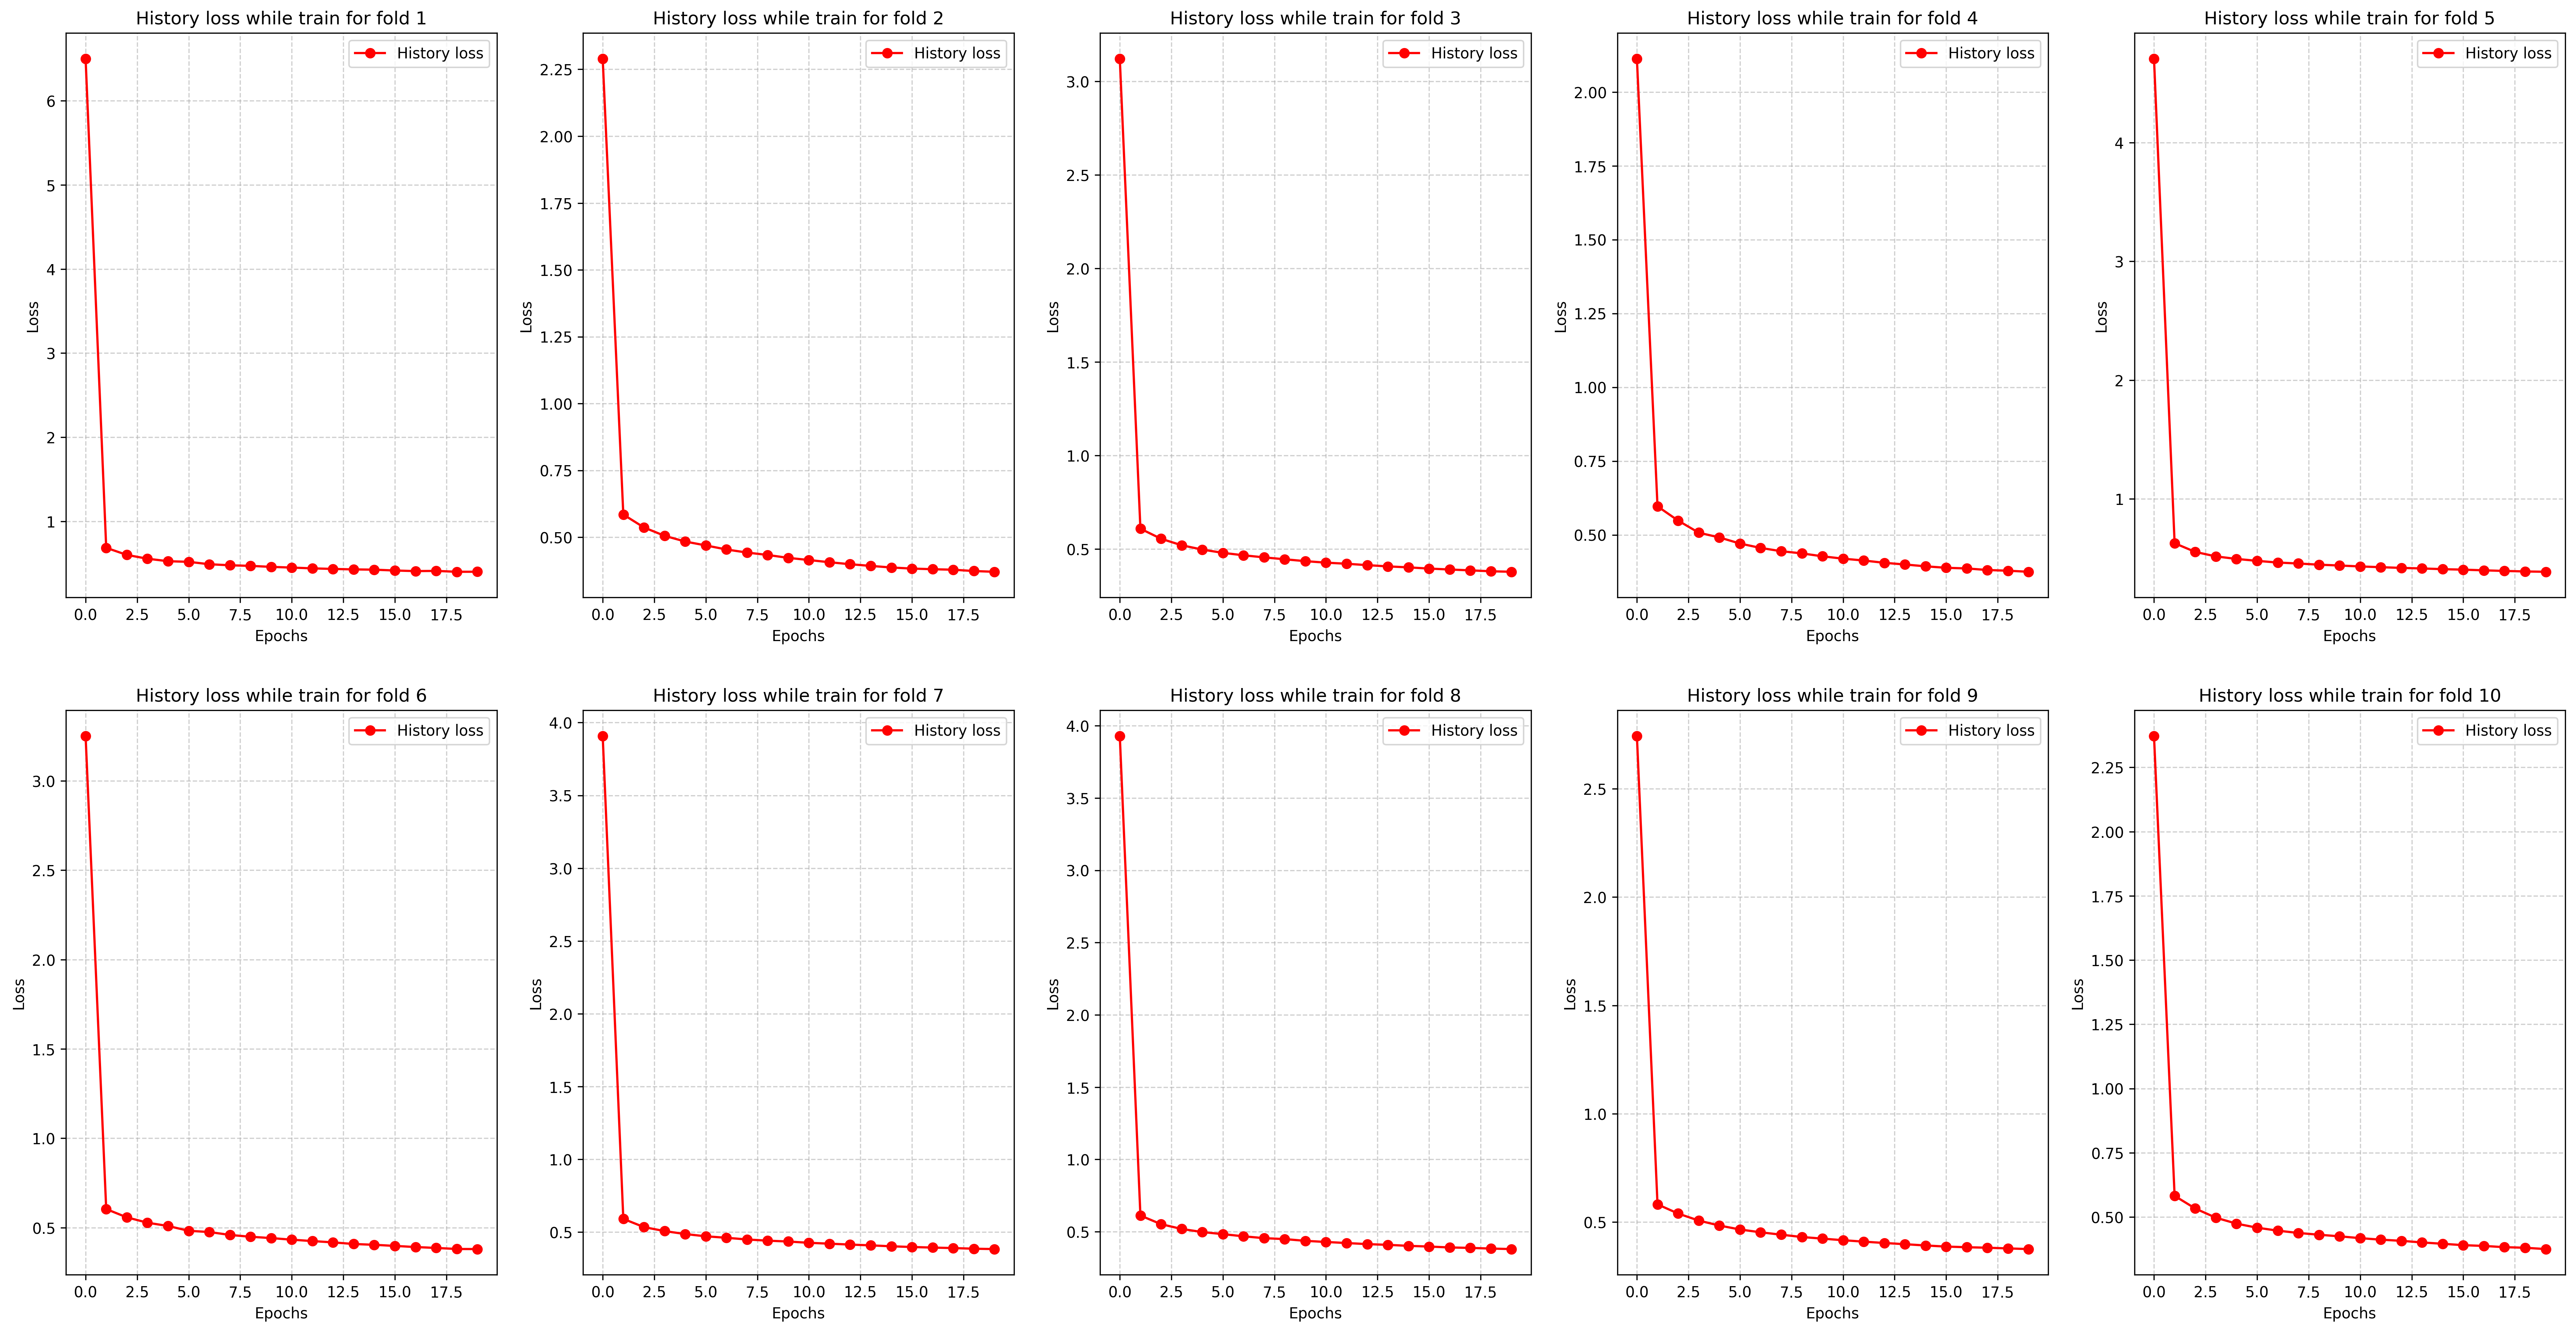

In [68]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "History loss while train"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 15), dpi=300)  # Kích thước tổng thể lớn để chứa 10 biểu đồ
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.2)  # Tăng khoảng cách giữa các ô

# Vẽ từng biểu đồ loss vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(foldloss[i], label='History loss', color='r', marker='o')
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'History loss while train for fold {i+1}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

# Điều chỉnh khoảng cách và lưu figure tổng hợp
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_loss_curves.png"), dpi=300)
plt.show()

In [70]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "AUC_ROC"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 15), dpi=800)  # Kích thước tổng thể lớn để chứa 10 biểu đồ
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.2)  # Tăng khoảng cách giữa các ô

# Vẽ từng biểu đồ AUC_ROC vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(foldvalroc[i], label=f'AUC_ROC', color='r', marker='o')
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel('AUC', fontsize=10)
    ax.set_title(f'AUC_ROC while train for fold {i}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

# Điều chỉnh khoảng cách và lưu figure tổng hợp
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_auc_roc_curves.png"), dpi=800)
plt.show()

<ipython-input-70-e91a02f42db4>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [ ]:
mean_val = np.mean(np.max(foldvalroc, axis=1))
print(f"Trung bình chỉ số AUC_ROC trên tập valid {mean_val}")

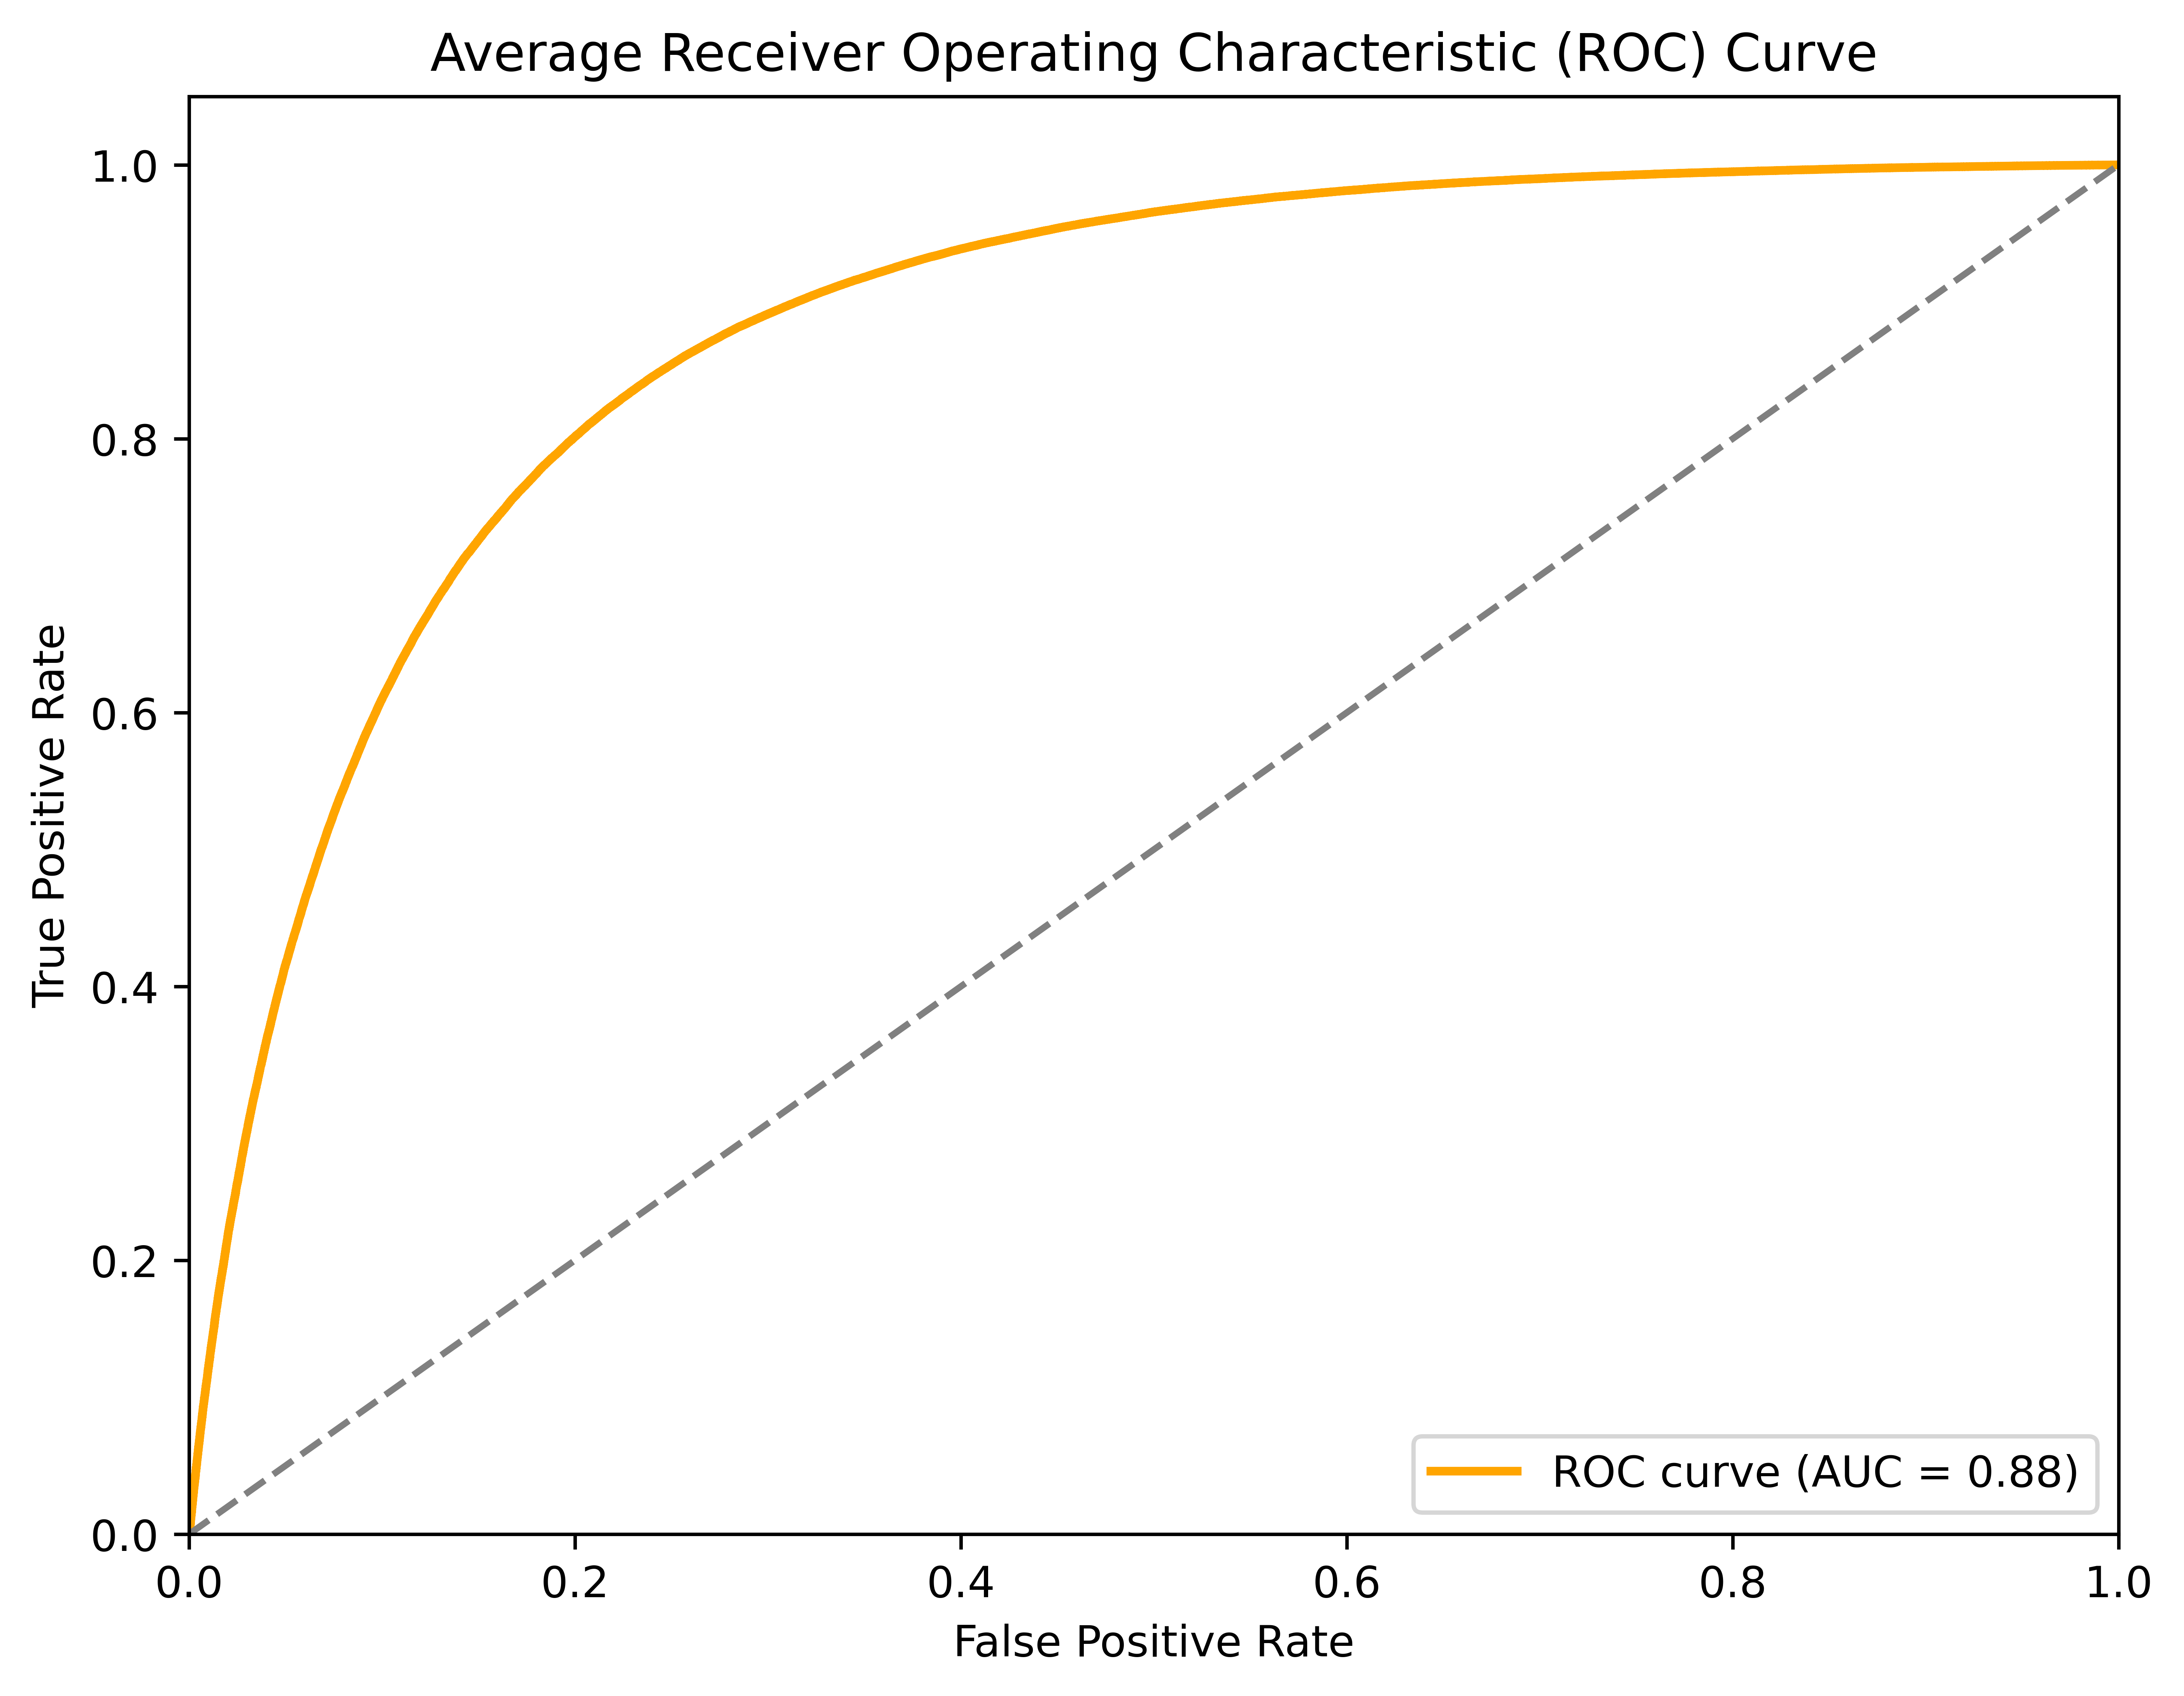

In [72]:
y_true = np.array(truth).flatten()
y_socre = np.array(predict).flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_socre)

# Tính AUC
roc_auc = roc_auc_score(y_true, y_socre)
plt.figure(figsize=(8, 6), dpi=800)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Đường chéo ngẫu nhiên
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Average Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='lower right')
plt.savefig("Average Receiver Operating Characteristic (ROC) Curve.png")
plt.show()


# Evaluation

In [ ]:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

In [ ]:
#sage conv
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
print(pred)
print(ground_truth)

In [ ]:
pred_ = pred.flatten()
ground_truth_ = ground_truth.flatten()

In [ ]:
pred_.shape, ground_truth_.shape

In [ ]:
np.unique(ground_truth)

In [ ]:
np.unique(pred)

In [ ]:
pred.min()

In [ ]:
plt.hist(pred, label='Ground Trust', color='orange')
plt.hist(ground_truth, label='Ground Truth', color='blue')


# Thêm tiêu đề và nhãn
plt.title('Histogram of Continuous Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()


In [ ]:
accuracy = np.mean(pred == ground_truth)
print(f"Validation Accuracy: {accuracy:.4f}")


In [ ]:
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
sageconvauc=round(auc,4)

# Inferences

In [ ]:
user_id = int(input('Enter user_id: '))

all_movies = torch.arange(data["movie"].num_nodes)

users = torch.full((data["movie"].num_nodes,), user_id)
print(users)

edge_index_test = torch.stack([users, all_movies], dim=0)
print(len(edge_index_test[0]))
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
original_user_edges = edge_index_user_to_movie[:, edge_index_user_to_movie[0] == user_id]
original_user_edges_set = set(tuple(edge) for edge in original_user_edges.t().tolist())
mask = [tuple(edge) not in original_user_edges_set for edge in edge_index_test.t().tolist()]
edge_index_test = edge_index_test[:, mask]
print(len(edge_index_test[0]))


test_data = HeteroData()


test_data["user"].node_id = torch.arange(len(unique_user_id))
test_data["movie"].node_id = torch.arange(len(movies))

test_data["user", "rates", "movie"].edge_index = edge_index_test
test_data["user"].x = user_features
test_data["movie"].x = movie_features
test_data = T.ToUndirected()(test_data)
print(test_data["user", "rates", "movie"].edge_index)

model.eval()
with torch.no_grad():
    pred_test = model(test_data)
print(pred_test.shape)
# max_rating_index = pred_test.argmax()
_, top_k_movie_indices = torch.topk(pred_test, 10)
recommended_movie = all_movies[top_k_movie_indices]

print(f"The recommended movie for user {user_id} is movie {recommended_movie}.")


# Visualize

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

movies_subset = movies.iloc[1:,0].head(25).tolist()
movies_subset = [int(movie_id) for movie_id in movies_subset]
users_subset = ratings['user_id'].head(25).tolist()
ratings_subset = ratings[(ratings['movie_id'].isin(movies_subset)) & (ratings['user_id'].isin(users_subset))]
users_with_most_ratings = ratings['user_id'].value_counts().head(25).index.tolist()
ratings_subset = ratings[(ratings['movie_id'].isin(movies_subset)) & (ratings['user_id'].isin(users_with_most_ratings))]

B = nx.Graph()

B.add_nodes_from(movies_subset, bipartite=0)
B.add_nodes_from(users_with_most_ratings, bipartite=1)

for _, row in ratings_subset.iterrows():
    B.add_edge(row['user_id'], row['movie_id'])

node_colors = ['skyblue' if n in movies_subset else 'lightgreen' for n in B.nodes]

plt.figure(figsize=(12, 8))
pos = nx.bipartite_layout(B, nodes=movies_subset)
nx.draw(B, pos, node_size=300, with_labels=True, font_size=8, node_color=node_colors, alpha=0.8, font_color='black', edge_color='gray')
plt.title("Bipartite Graph for a Subset of movielens dataset")
plt.show()

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt

num_users_to_sample = 1
sampled_user_ids = [200]
print(sampled_user_ids)
sampled_edge_indices = edge_index_user_to_movie[:, ratings['user_id'] == sampled_user_ids[0]]
G = nx.DiGraph()
G.add_node("User", label="User")
for movie_id in sampled_edge_indices[1].unique():
    G.add_node(movie_id.item(), label="Movie")
for movie_id in sampled_edge_indices[1]:
    G.add_edge("User", movie_id.item())

user_id = sampled_user_ids[0]
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', alpha=0.8)
plt.title("User-Movie Interaction Graph for 1 User with User ID: " + str(user_id))  # Concatenate the string and user_id
plt.show()